# LME銅 Cash/3Mスプレッド出来高・流動性分析

## 分析目的
このノートブックは、LME銅Cash/3Mスプレッドの出来高と流動性特性を分析し、以下を理解します：
1. **スプレッド流動性分布**: スプレッド取引の活発度と集中度
2. **時間的パターン**: スプレッド取引出来高の時間的変化
3. **市場参加**: スプレッド取引者の行動パターン
4. **取引効率**: スプレッド取引のコストと実行品質

## 主要指標と解釈
- **スプレッド出来高**: Cash/3Mスプレッド専用取引量
- **出来高集中度**: 特定期間でのスプレッド取引集中
- **スプレッド効率**: 出来高当たりのスプレッド変動性
- **流動性深度**: 継続的なスプレッド取引活動
- **裁定機会**: 異常なスプレッドボラティリティ期間

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv

warnings.filterwarnings('ignore')
load_dotenv()

# Try to import plotly, but continue without it if not available
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    print("Plotly not available. Using matplotlib for all visualizations.")
    PLOTLY_AVAILABLE = False

# データベース設定
db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'lme_copper_db'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'password'),
    'port': os.getenv('DB_PORT', '5432')
}

# Create connection string
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"

# スタイル設定
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = [12, 8]

## データ読み込みと準備

In [12]:
def load_spread_data():
    """PostgreSQLからLME銅Cash/3Mスプレッドデータを読み込み"""
    try:
        engine = create_engine(connection_string)
        
        # Cash/3Mスプレッド専用データを取得
        spread_query = """
        SELECT 
            trade_date,
            ric,
            last_price as spread_price,
            volume,
            price_type
        FROM lme_copper_prices
        WHERE price_type = 'CASH_3M_SPREAD' 
        AND last_price IS NOT NULL 
        AND volume IS NOT NULL
        ORDER BY trade_date
        """
        
        spread_df = pd.read_sql_query(spread_query, engine)
        
        # 参照用のCashと3Mデータも取得（スプレッド構成要素として）
        components_query = """
        SELECT 
            trade_date,
            ric,
            last_price,
            volume,
            price_type
        FROM lme_copper_prices
        WHERE price_type IN ('CASH', '3M') 
        AND last_price IS NOT NULL
        ORDER BY trade_date, price_type
        """
        
        components_df = pd.read_sql_query(components_query, engine)
        engine.dispose()
        
        # データ前処理
        spread_df['trade_date'] = pd.to_datetime(spread_df['trade_date'])
        components_df['trade_date'] = pd.to_datetime(components_df['trade_date'])
        
        # スプレッドデータに時間要素を追加
        spread_df['year'] = spread_df['trade_date'].dt.year
        spread_df['month'] = spread_df['trade_date'].dt.month
        spread_df['quarter'] = spread_df['trade_date'].dt.quarter
        spread_df['day_of_week'] = spread_df['trade_date'].dt.day_name()
        spread_df['month_name'] = spread_df['trade_date'].dt.month_name()
        
        # スプレッド固有メトリクス計算
        spread_df['abs_spread'] = abs(spread_df['spread_price'])
        spread_df['spread_direction'] = np.where(spread_df['spread_price'] > 0, 'Backwardation', 'Contango')
        spread_df['volume_usd'] = spread_df['volume'] * spread_df['abs_spread']  # 絶対値での取引金額
        
        print(f"スプレッドデータ読み込み完了: {len(spread_df):,}件のレコード")
        print(f"期間: {spread_df['trade_date'].min()} ～ {spread_df['trade_date'].max()}")
        print(f"スプレッド範囲: {spread_df['spread_price'].min():.2f} ～ {spread_df['spread_price'].max():.2f} USD/ton")
        
        return spread_df, components_df
    
    except Exception as e:
        print(f"データ読み込みエラー: {e}")
        return None, None

# データ読み込み
spread_df, components_df = load_spread_data()

スプレッドデータ読み込み完了: 730件のレコード
期間: 2022-07-06 00:00:00 ～ 2025-07-04 00:00:00
スプレッド範囲: -161.41 ～ 319.83 USD/ton


## 1. スプレッド出来高分布分析

### 解釈ガイド:
- **高出来高期間**: アクティブなスプレッド取引は市場構造変化を示す
- **バックワーデーション時**: 正スプレッドでの高出来高は供給制約を示唆
- **コンタンゴ時**: 負スプレッドでの高出来高は過剰供給や在庫積み増しを示唆
- **出来高集中**: 特定期間の集中は重要な市場イベントを示す可能性

In [13]:
if spread_df is not None:
    # 基本統計
    print("Cash/3Mスプレッド出来高分析:")
    print("="*50)
    print(f"平均日次出来高: {spread_df['volume'].mean():,.0f}")
    print(f"中央値日次出来高: {spread_df['volume'].median():,.0f}")
    print(f"最大日次出来高: {spread_df['volume'].max():,.0f}")
    print(f"最小日次出来高: {spread_df['volume'].min():,.0f}")
    print(f"総出来高: {spread_df['volume'].sum():,.0f}")
    
    # スプレッド方向別出来高分析
    direction_volume = spread_df.groupby('spread_direction').agg({
        'volume': ['sum', 'mean', 'count'],
        'spread_price': ['mean', 'std'],
        'abs_spread': 'mean'
    }).round(2)
    
    direction_volume.columns = ['total_volume', 'avg_daily_volume', 'trading_days', 
                               'avg_spread', 'spread_volatility', 'avg_abs_spread']
    
    print("\nスプレッド方向別出来高:")
    print("="*50)
    display(direction_volume)
    
    # 移動平均計算
    spread_df_sorted = spread_df.sort_values('trade_date')
    spread_df_sorted['volume_ma_30'] = spread_df_sorted['volume'].rolling(30).mean()
    spread_df_sorted['volume_ma_90'] = spread_df_sorted['volume'].rolling(90).mean()
    spread_df_sorted['spread_volatility'] = spread_df_sorted['spread_price'].rolling(30).std()
else:
    print("データが読み込まれていません")

Cash/3Mスプレッド出来高分析:
平均日次出来高: 61
中央値日次出来高: 34
最大日次出来高: 612
最小日次出来高: 1
総出来高: 44,578

スプレッド方向別出来高:


,total_volume,avg_daily_volume,trading_days,avg_spread,spread_volatility,avg_abs_spread
spread_direction,,,,,,
Backwardation,5814,43.71,133,57.43,56.52,57.43
Contango,38764,64.93,597,-75.65,46.26,75.65


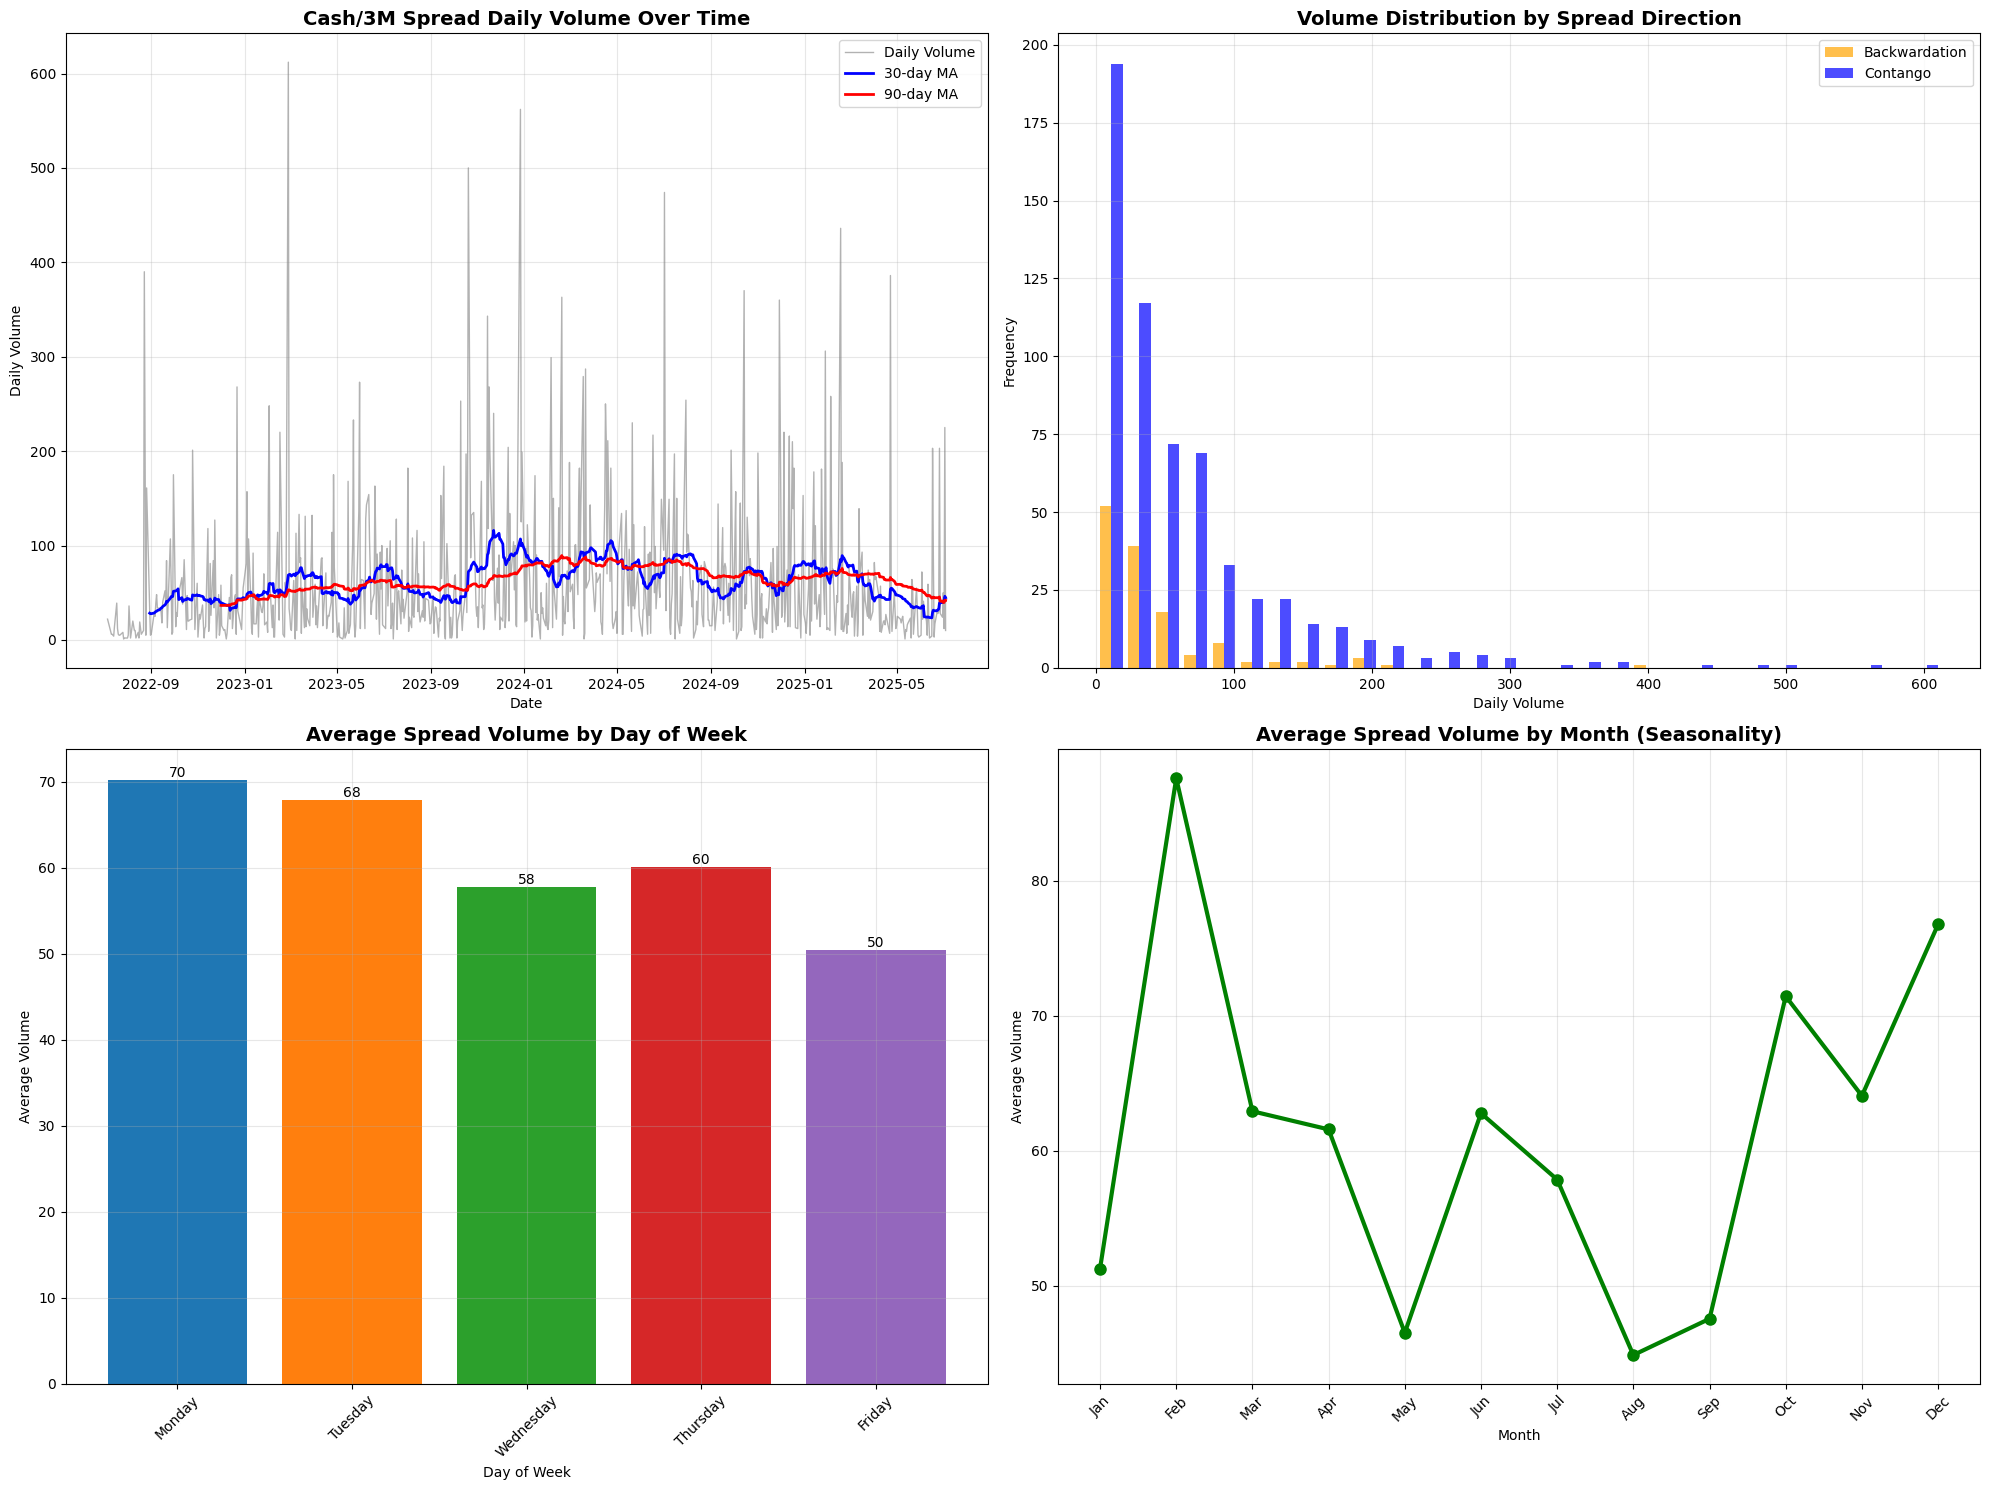

In [14]:
if spread_df is not None:
    # スプレッド出来高分布可視化
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 出来高時系列
    ax1.plot(spread_df_sorted['trade_date'], spread_df_sorted['volume'], 
             alpha=0.6, linewidth=1, color='gray', label='Daily Volume')
    ax1.plot(spread_df_sorted['trade_date'], spread_df_sorted['volume_ma_30'], 
             linewidth=2, color='blue', label='30-day MA')
    ax1.plot(spread_df_sorted['trade_date'], spread_df_sorted['volume_ma_90'], 
             linewidth=2, color='red', label='90-day MA')
    ax1.set_title('Cash/3M Spread Daily Volume Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Volume')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. スプレッド方向別出来高分布
    back_volume = spread_df[spread_df['spread_direction'] == 'Backwardation']['volume']
    cont_volume = spread_df[spread_df['spread_direction'] == 'Contango']['volume']
    
    ax2.hist([back_volume, cont_volume], bins=30, alpha=0.7, 
             label=['Backwardation', 'Contango'], color=['orange', 'blue'])
    ax2.set_title('Volume Distribution by Spread Direction', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Daily Volume')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. 曜日別出来高
    dow_volume = spread_df.groupby('day_of_week')['volume'].mean().reindex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    bars = ax3.bar(dow_volume.index, dow_volume.values, 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    ax3.set_title('Average Spread Volume by Day of Week', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Day of Week')
    ax3.set_ylabel('Average Volume')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # 値ラベル追加
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:,.0f}', ha='center', va='bottom')
    
    # 4. 月別出来高（季節性）
    monthly_volume = spread_df.groupby('month_name')['volume'].mean().reindex(
        ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December'])
    ax4.plot(range(len(monthly_volume)), monthly_volume.values, 
             marker='o', linewidth=3, markersize=8, color='green')
    ax4.set_title('Average Spread Volume by Month (Seasonality)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Month')
    ax4.set_ylabel('Average Volume')
    ax4.set_xticks(range(len(monthly_volume)))
    ax4.set_xticklabels([m[:3] for m in monthly_volume.index], rotation=45)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/spread_volume_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

## 2. スプレッド流動性効率分析

### 解釈ガイド:
- **効率的期間**: 高出来高・低ボラティリティは効率的なスプレッド取引を示す
- **非効率期間**: 低出来高・高ボラティリティは流動性制約を示す
- **裁定機会**: 異常に高いスプレッドボラティリティは価格乖離を示唆
- **取引コスト**: 出来高当たりのスプレッド変動は実行コストを反映

In [15]:
if spread_df is not None:
    # 流動性効率指標計算
    spread_df_sorted['spread_change'] = spread_df_sorted['spread_price'].pct_change() * 100
    spread_df_sorted['abs_spread_change'] = abs(spread_df_sorted['spread_change'])
    spread_df_sorted['volume_change'] = spread_df_sorted['volume'].pct_change() * 100
    
    # 30日間のローリング指標
    spread_df_sorted['efficiency_ratio'] = (
        spread_df_sorted['volume'].rolling(30).mean() / 
        spread_df_sorted['abs_spread_change'].rolling(30).mean()
    )
    
    # 出来高-ボラティリティ相関
    volume_volatility_corr = spread_df_sorted['volume'].corr(spread_df_sorted['abs_spread_change'])
    volume_spread_corr = spread_df_sorted['volume'].corr(spread_df_sorted['spread_change'])
    
    print(f"スプレッド流動性効率分析:")
    print(f"出来高-スプレッドボラティリティ相関: {volume_volatility_corr:.3f}")
    print(f"出来高-スプレッド変化相関: {volume_spread_corr:.3f}")
    
    # 高出来高期間の特定（上位10%）
    volume_threshold = spread_df_sorted['volume'].quantile(0.9)
    high_volume_periods = spread_df_sorted[spread_df_sorted['volume'] > volume_threshold]
    normal_periods = spread_df_sorted[spread_df_sorted['volume'] <= volume_threshold]
    
    print(f"\n高出来高期間の特性（上位10%）:")
    print(f"高出来高期間の平均スプレッド変化: {high_volume_periods['abs_spread_change'].mean():.2f}%")
    print(f"通常期間の平均スプレッド変化: {normal_periods['abs_spread_change'].mean():.2f}%")
    print(f"高出来高期間の平均スプレッド: {high_volume_periods['spread_price'].mean():.2f} USD/ton")
    print(f"通常期間の平均スプレッド: {normal_periods['spread_price'].mean():.2f} USD/ton")

スプレッド流動性効率分析:
出来高-スプレッドボラティリティ相関: nan
出来高-スプレッド変化相関: nan

高出来高期間の特性（上位10%）:
高出来高期間の平均スプレッド変化: 22.79%
通常期間の平均スプレッド変化: inf%
高出来高期間の平均スプレッド: -68.54 USD/ton
通常期間の平均スプレッド: -49.50 USD/ton


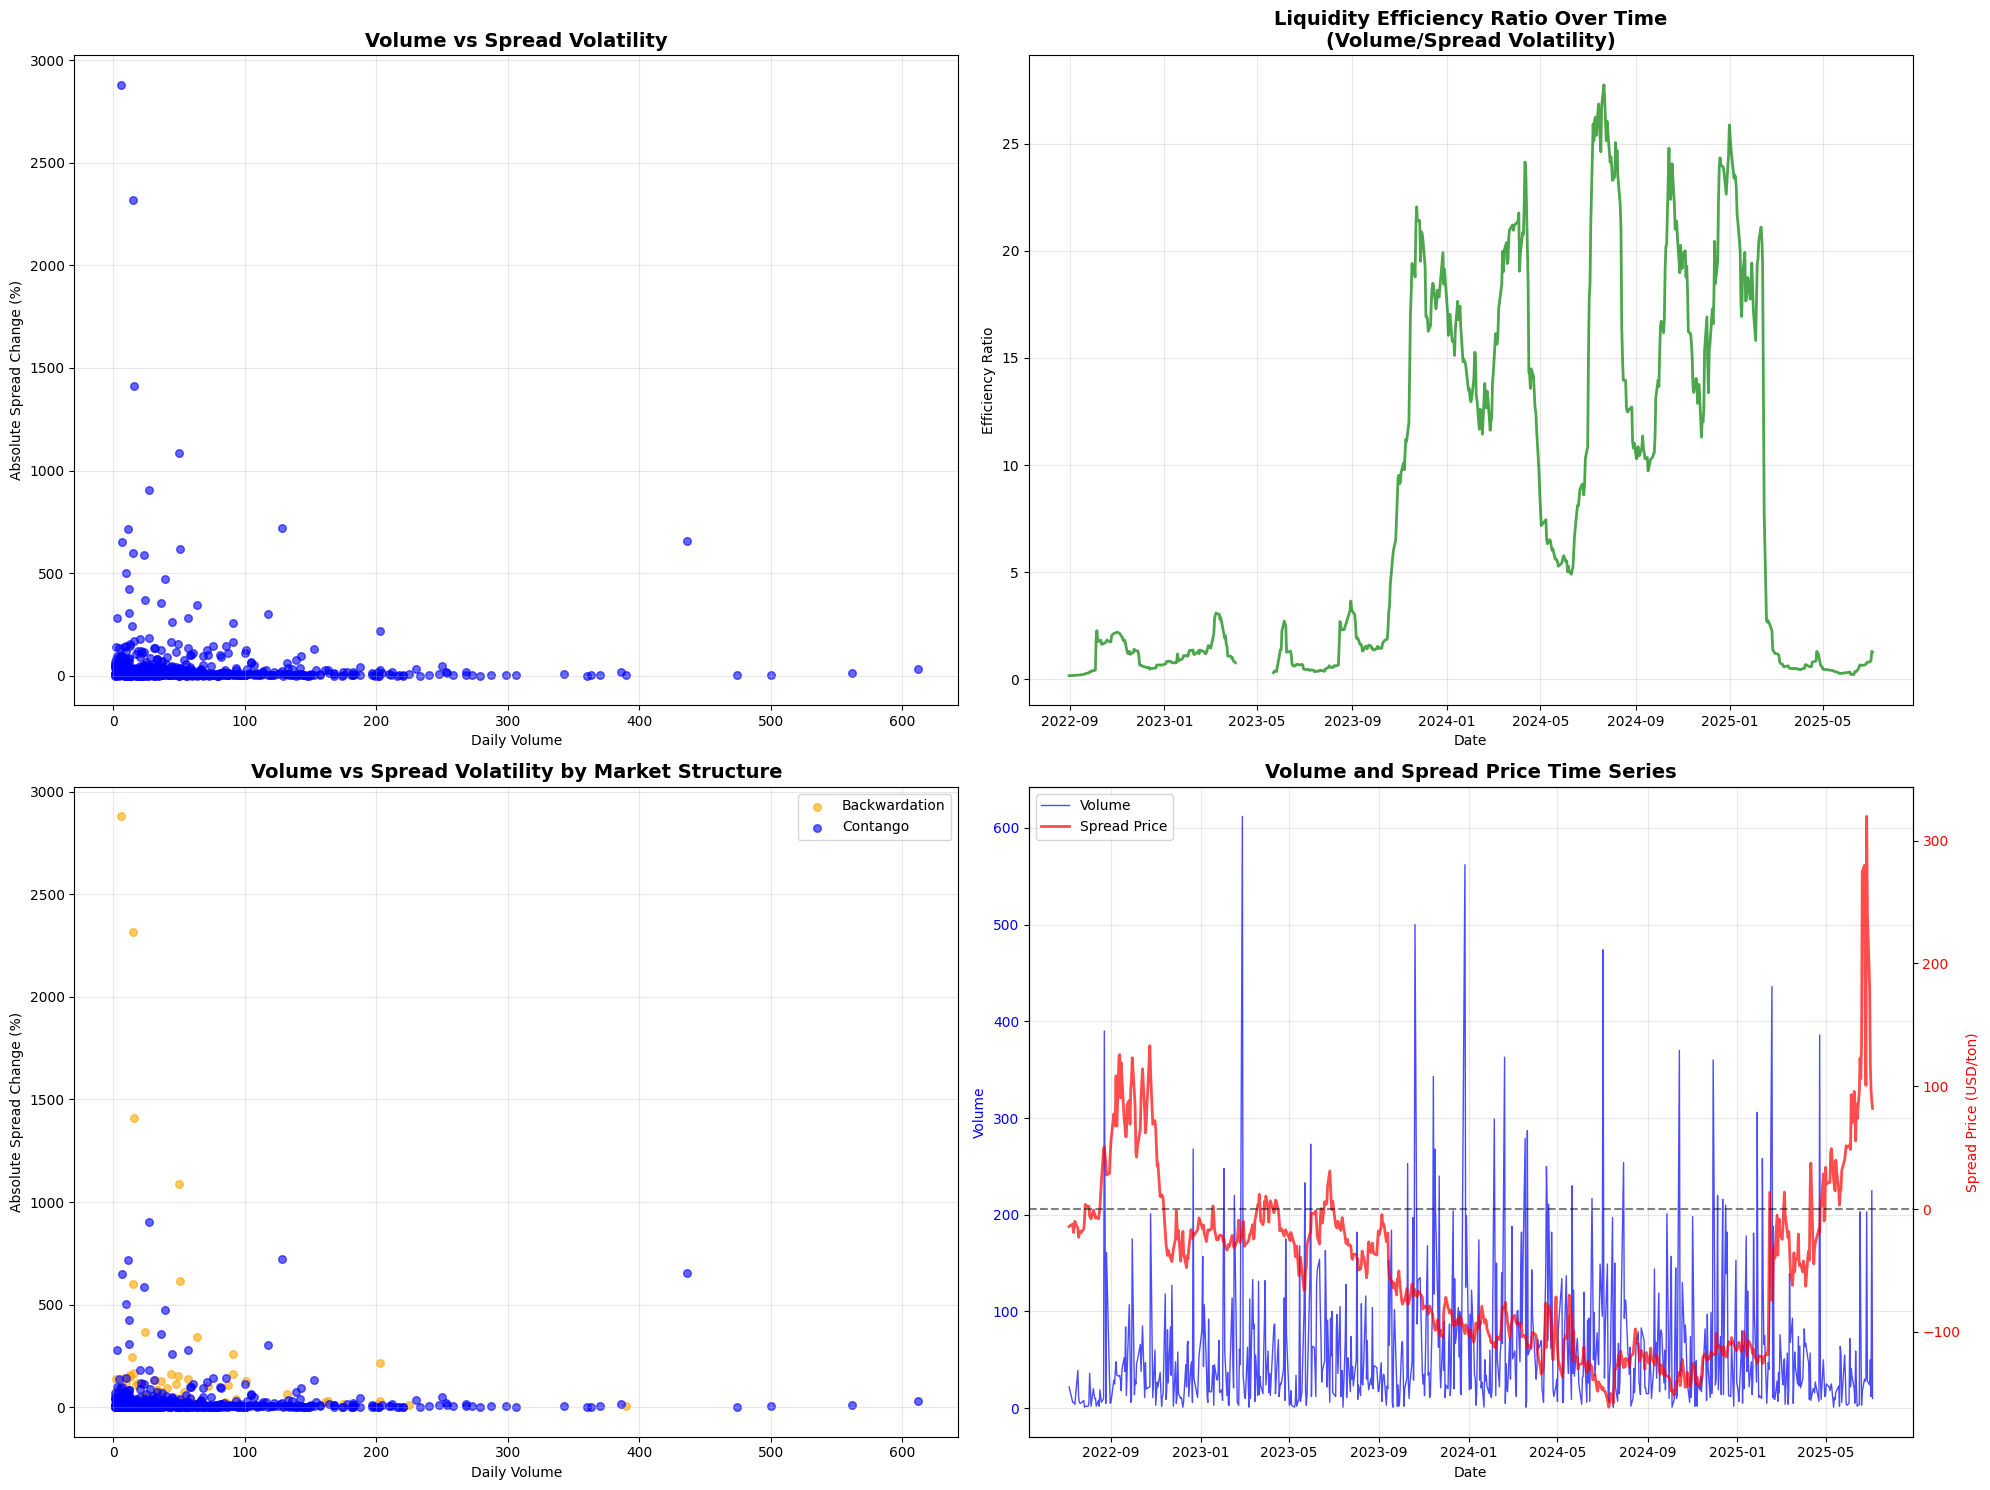

In [16]:
if spread_df is not None:
    # 流動性効率可視化
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 出来高 vs スプレッドボラティリティ
    ax1.scatter(spread_df_sorted['volume'], spread_df_sorted['abs_spread_change'], 
               alpha=0.6, s=30, color='blue')
    # トレンドライン追加
    valid_data = spread_df_sorted.dropna(subset=['volume', 'abs_spread_change'])
    if len(valid_data) > 0:
        z = np.polyfit(valid_data['volume'], valid_data['abs_spread_change'], 1)
        p = np.poly1d(z)
        ax1.plot(valid_data['volume'], p(valid_data['volume']), "r--", alpha=0.8, linewidth=2)
    ax1.set_title('Volume vs Spread Volatility', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Daily Volume')
    ax1.set_ylabel('Absolute Spread Change (%)')
    ax1.grid(True, alpha=0.3)
    
    # 2. 効率性比率の時系列
    ax2.plot(spread_df_sorted['trade_date'], spread_df_sorted['efficiency_ratio'], 
             linewidth=2, color='green', alpha=0.7)
    ax2.set_title('Liquidity Efficiency Ratio Over Time\n(Volume/Spread Volatility)', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Efficiency Ratio')
    ax2.grid(True, alpha=0.3)
    
    # 3. スプレッド方向別出来高-ボラティリティ関係
    back_data = spread_df_sorted[spread_df_sorted['spread_direction'] == 'Backwardation']
    cont_data = spread_df_sorted[spread_df_sorted['spread_direction'] == 'Contango']
    
    ax3.scatter(back_data['volume'], back_data['abs_spread_change'], 
               alpha=0.6, s=30, color='orange', label='Backwardation')
    ax3.scatter(cont_data['volume'], cont_data['abs_spread_change'], 
               alpha=0.6, s=30, color='blue', label='Contango')
    ax3.set_title('Volume vs Spread Volatility by Market Structure', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Daily Volume')
    ax3.set_ylabel('Absolute Spread Change (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. 出来高とスプレッド価格の二重軸プロット
    ax4_twin = ax4.twinx()
    
    line1 = ax4.plot(spread_df_sorted['trade_date'], spread_df_sorted['volume'], 
                     color='blue', alpha=0.7, linewidth=1, label='Volume')
    line2 = ax4_twin.plot(spread_df_sorted['trade_date'], spread_df_sorted['spread_price'], 
                          color='red', alpha=0.7, linewidth=2, label='Spread Price')
    
    ax4.set_title('Volume and Spread Price Time Series', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Volume', color='blue')
    ax4_twin.set_ylabel('Spread Price (USD/ton)', color='red')
    ax4.tick_params(axis='y', labelcolor='blue')
    ax4_twin.tick_params(axis='y', labelcolor='red')
    
    # ゼロライン追加
    ax4_twin.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 凡例結合
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax4.legend(lines, labels, loc='upper left')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/spread_liquidity_efficiency.png', dpi=300, bbox_inches='tight')
    plt.show()

## 3. 市場参加者行動分析

### 解釈ガイド:
- **大口取引**: 異常に高い出来高は機関投資家活動を示唆
- **頻繁な小口取引**: 継続的な低出来高は個人投資家活動を示唆
- **スプレッド変動**: 急激な変化は情報による取引を示す可能性
- **取引クラスター**: 集中的取引は重要なニュースイベントを示唆

In [17]:
if spread_df is not None:
    # 取引サイズ分類
    volume_percentiles = spread_df['volume'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
    
    # 取引サイズカテゴリ作成
    def categorize_volume(volume):
        if volume <= volume_percentiles[0.25]:
            return 'Small (Bottom 25%)'
        elif volume <= volume_percentiles[0.5]:
            return 'Medium-Small (25-50%)'
        elif volume <= volume_percentiles[0.75]:
            return 'Medium (50-75%)'
        elif volume <= volume_percentiles[0.9]:
            return 'Large (75-90%)'
        elif volume <= volume_percentiles[0.95]:
            return 'Very Large (90-95%)'
        else:
            return 'Institutional (Top 5%)'
    
    spread_df_sorted['volume_category'] = spread_df_sorted['volume'].apply(categorize_volume)
    
    # カテゴリ別分析
    category_analysis = spread_df_sorted.groupby('volume_category').agg({
        'volume': ['count', 'mean', 'sum'],
        'spread_price': ['mean', 'std'],
        'abs_spread_change': 'mean'
    }).round(3)
    
    category_analysis.columns = ['trade_count', 'avg_volume', 'total_volume', 
                                'avg_spread', 'spread_std', 'avg_volatility']
    
    # 各カテゴリの市場影響
    category_analysis['market_share'] = (
        category_analysis['total_volume'] / category_analysis['total_volume'].sum() * 100
    ).round(1)
    
    print("取引サイズ別市場参加者分析:")
    print("="*60)
    display(category_analysis)
    
    # 大口取引の特徴
    large_trades = spread_df_sorted[spread_df_sorted['volume'] > volume_percentiles[0.9]]
    print(f"\n大口取引分析（上位10%）:")
    print(f"大口取引回数: {len(large_trades)}")
    print(f"平均スプレッド影響: {large_trades['abs_spread_change'].mean():.2f}%")
    print(f"バックワーデーション比率: {(large_trades['spread_direction'] == 'Backwardation').mean():.1%}")

取引サイズ別市場参加者分析:


,trade_count,avg_volume,total_volume,avg_spread,spread_std,avg_volatility,market_share
volume_category,,,,,,,
Institutional (Top 5%),37,299.541,11083,-64.600,89.196,32.635,24.9
Large (75-90%),109,105.761,11528,-71.125,58.831,30.648,25.9
Medium (50-75%),183,53.694,9826,-57.677,64.616,38.991,22.0
Medium-Small (25-50%),181,24.580,4449,-36.539,80.183,inf,10.0
Small (Bottom 25%),184,7.967,1466,-41.302,64.648,71.830,3.3
Very Large (90-95%),36,172.944,6226,-72.591,65.548,12.673,14.0



大口取引分析（上位10%）:
大口取引回数: 73
平均スプレッド影響: 22.79%
バックワーデーション比率: 11.0%


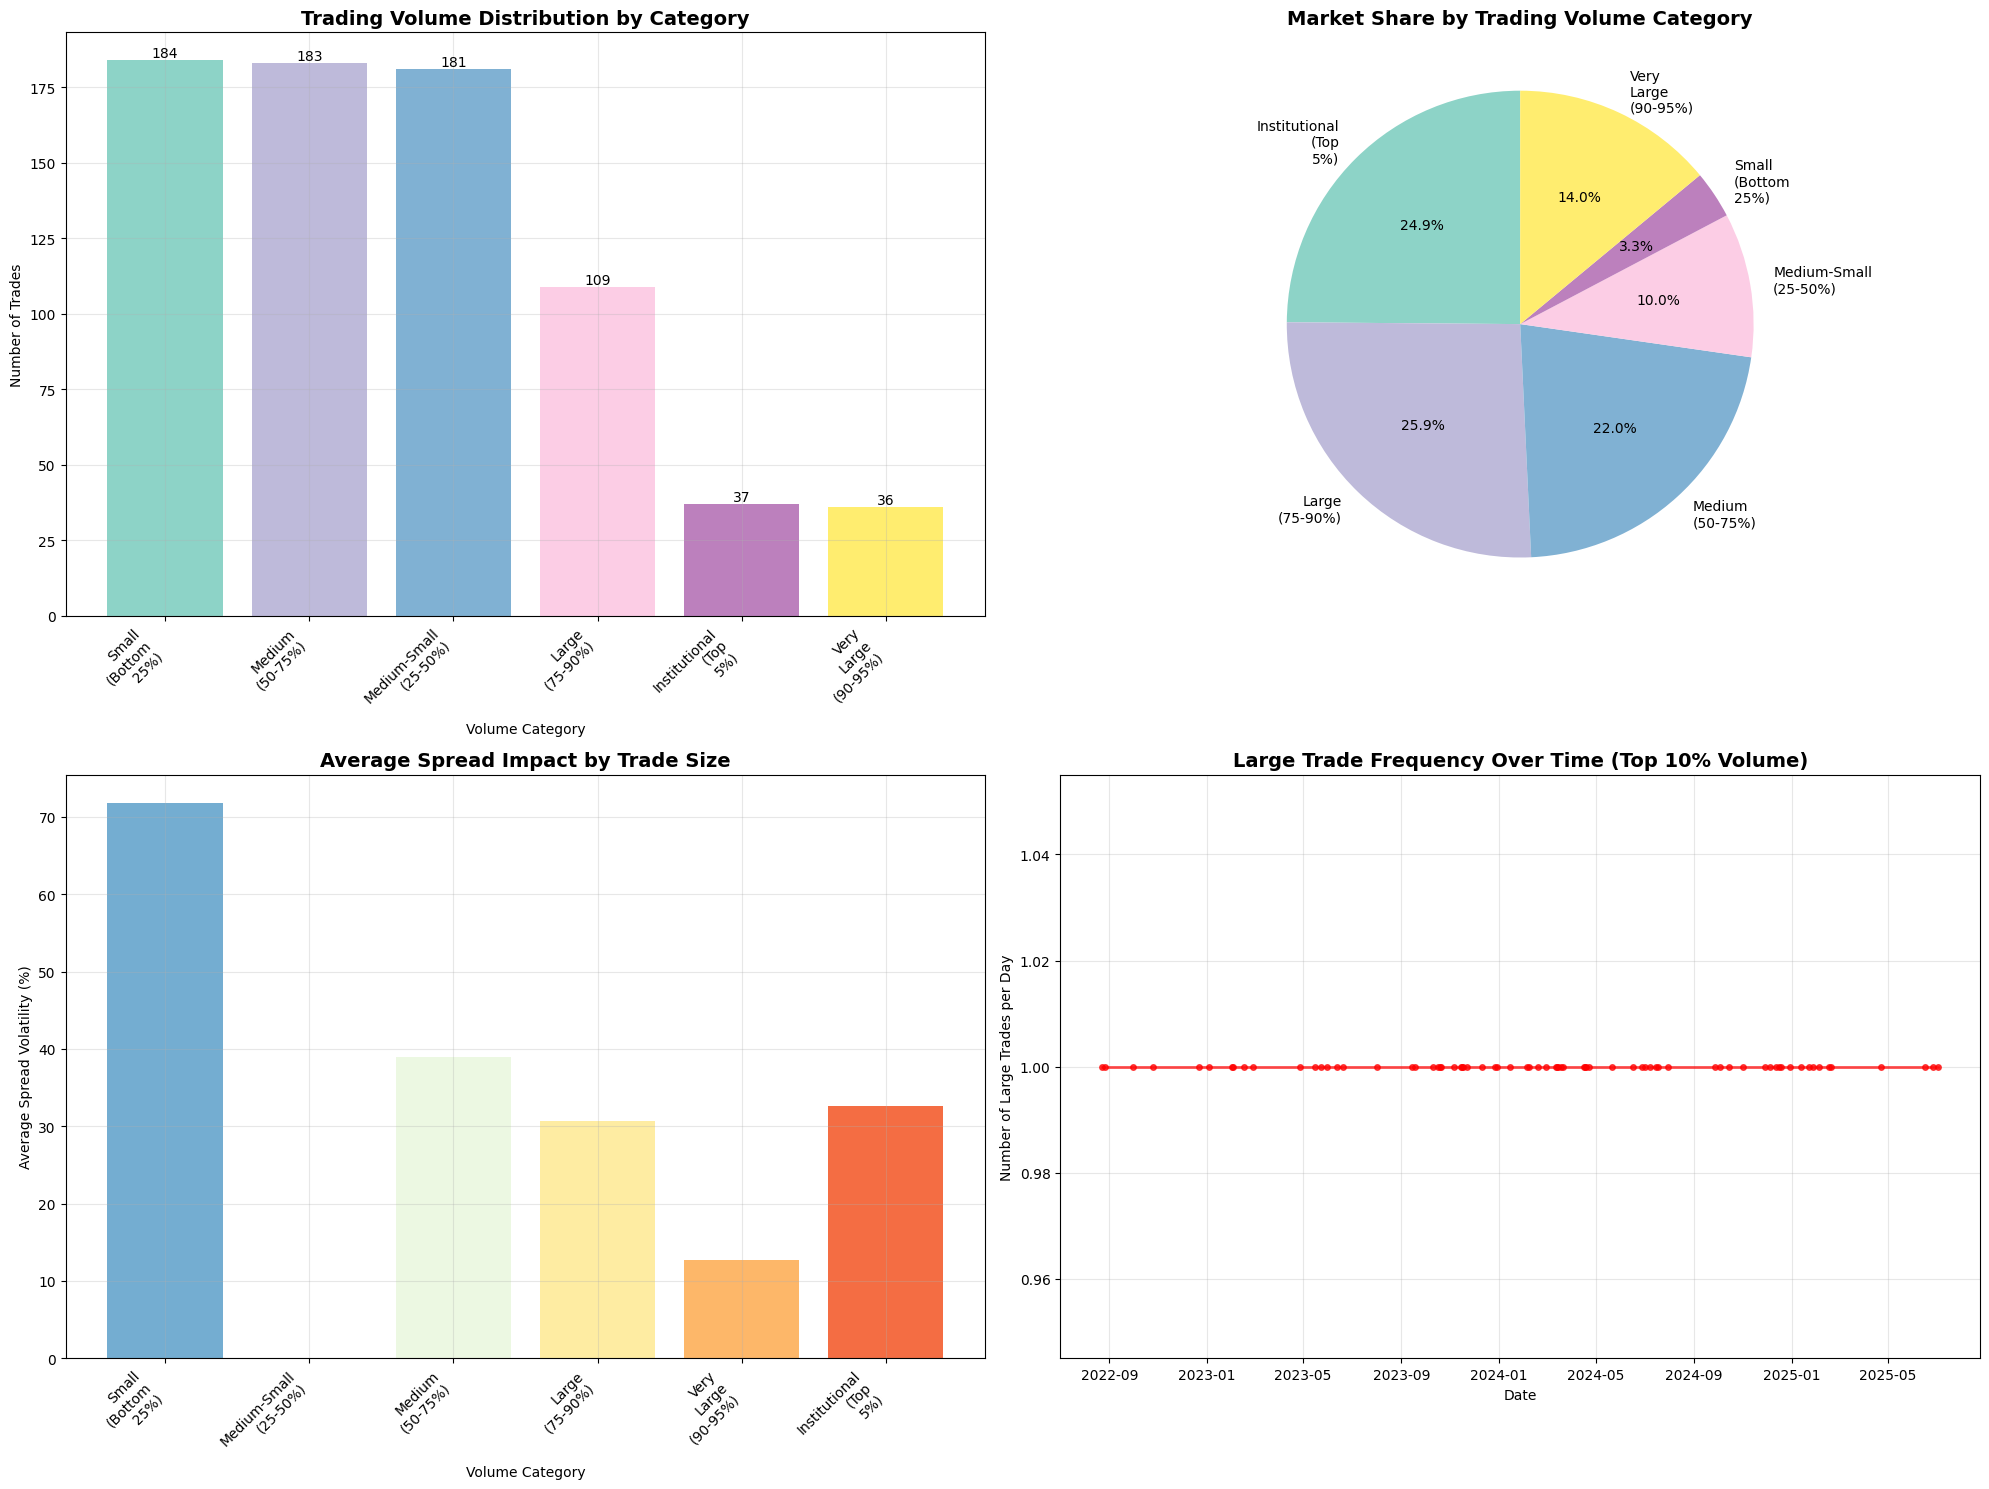

In [18]:
if spread_df is not None:
    # 市場参加者行動可視化
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 取引サイズ分布
    volume_counts = spread_df_sorted['volume_category'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(volume_counts)))
    bars = ax1.bar(range(len(volume_counts)), volume_counts.values, color=colors)
    ax1.set_title('Trading Volume Distribution by Category', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Volume Category')
    ax1.set_ylabel('Number of Trades')
    ax1.set_xticks(range(len(volume_counts)))
    ax1.set_xticklabels([cat.replace(' ', '\n') for cat in volume_counts.index], rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # 値ラベル追加
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}', ha='center', va='bottom')
    
    # 2. 市場シェア円グラフ
    wedges, texts, autotexts = ax2.pie(category_analysis['market_share'], 
                                       labels=[idx.replace(' ', '\n') for idx in category_analysis.index],
                                       autopct='%1.1f%%', startangle=90, colors=colors)
    ax2.set_title('Market Share by Trading Volume Category', fontsize=14, fontweight='bold')
    
    # 3. 取引サイズ vs スプレッド影響
    category_order = ['Small (Bottom 25%)', 'Medium-Small (25-50%)', 'Medium (50-75%)', 
                     'Large (75-90%)', 'Very Large (90-95%)', 'Institutional (Top 5%)']
    
    impact_data = []
    for cat in category_order:
        if cat in category_analysis.index:
            impact_data.append(category_analysis.loc[cat, 'avg_volatility'])
        else:
            impact_data.append(0)
    
    bars3 = ax3.bar(range(len(category_order)), impact_data, 
                    color=plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(category_order))))
    ax3.set_title('Average Spread Impact by Trade Size', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Volume Category')
    ax3.set_ylabel('Average Spread Volatility (%)')
    ax3.set_xticks(range(len(category_order)))
    ax3.set_xticklabels([cat.replace(' ', '\n') for cat in category_order], rotation=45, ha='right')
    ax3.grid(True, alpha=0.3)
    
    # 4. 大口取引タイミング分析
    large_trades_daily = large_trades.groupby('trade_date').size()
    ax4.plot(large_trades_daily.index, large_trades_daily.values, 
             marker='o', linewidth=2, markersize=4, color='red', alpha=0.7)
    ax4.set_title('Large Trade Frequency Over Time (Top 10% Volume)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Number of Large Trades per Day')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/market_participant_behavior.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. スプレッド取引機会分析

### 解釈ガイド:
- **異常スプレッド**: 統計的外れ値は裁定機会を示唆
- **低出来高+異常スプレッド**: 流動性制約による価格歪み
- **高出来高+正常スプレッド**: 効率的な価格発見
- **スプレッド持続性**: 一時的vs構造的な価格乖離

In [19]:
if spread_df is not None:
    # 統計的異常値の特定
    spread_mean = spread_df['spread_price'].mean()
    spread_std = spread_df['spread_price'].std()
    
    # 2σと3σ閾値
    upper_2sigma = spread_mean + 2 * spread_std
    lower_2sigma = spread_mean - 2 * spread_std
    upper_3sigma = spread_mean + 3 * spread_std
    lower_3sigma = spread_mean - 3 * spread_std
    
    # 異常値分類
    spread_df_sorted['anomaly_level'] = 'Normal'
    spread_df_sorted.loc[
        (spread_df_sorted['spread_price'] > upper_2sigma) | 
        (spread_df_sorted['spread_price'] < lower_2sigma), 'anomaly_level'
    ] = '2-Sigma Outlier'
    spread_df_sorted.loc[
        (spread_df_sorted['spread_price'] > upper_3sigma) | 
        (spread_df_sorted['spread_price'] < lower_3sigma), 'anomaly_level'
    ] = '3-Sigma Outlier'
    
    # 取引機会分析
    anomaly_analysis = spread_df_sorted.groupby('anomaly_level').agg({
        'volume': ['count', 'mean'],
        'spread_price': ['mean', 'std'],
        'abs_spread_change': 'mean'
    }).round(3)
    
    anomaly_analysis.columns = ['occurrence_count', 'avg_volume', 'avg_spread', 'spread_std', 'avg_volatility']
    
    print("スプレッド異常値・取引機会分析:")
    print("="*50)
    print(f"平均スプレッド: {spread_mean:.2f} ± {spread_std:.2f} USD/ton")
    print(f"2σ範囲: {lower_2sigma:.2f} ～ {upper_2sigma:.2f} USD/ton")
    print(f"3σ範囲: {lower_3sigma:.2f} ～ {upper_3sigma:.2f} USD/ton")
    print("\n異常値レベル別分析:")
    display(anomaly_analysis)
    
    # 極端な異常値（3σ外）の詳細分析
    extreme_outliers = spread_df_sorted[spread_df_sorted['anomaly_level'] == '3-Sigma Outlier']
    if len(extreme_outliers) > 0:
        print(f"\n極端異常値（3σ外）分析:")
        print(f"発生回数: {len(extreme_outliers)}")
        print(f"平均出来高: {extreme_outliers['volume'].mean():,.0f}")
        print(f"最大スプレッド: {extreme_outliers['spread_price'].max():.2f} USD/ton")
        print(f"最小スプレッド: {extreme_outliers['spread_price'].min():.2f} USD/ton")

スプレッド異常値・取引機会分析:
平均スプレッド: -51.40 ± 70.50 USD/ton
2σ範囲: -192.41 ～ 89.60 USD/ton
3σ範囲: -262.91 ～ 160.10 USD/ton

異常値レベル別分析:


,occurrence_count,avg_volume,avg_spread,spread_std,avg_volatility
anomaly_level,,,,,
2-Sigma Outlier,25,50.040,110.036,15.860,31.248
3-Sigma Outlier,5,60.400,259.430,51.739,74.982
Normal,700,61.464,-59.389,58.931,inf



極端異常値（3σ外）分析:
発生回数: 5
平均出来高: 60
最大スプレッド: 319.83 USD/ton
最小スプレッド: 181.69 USD/ton


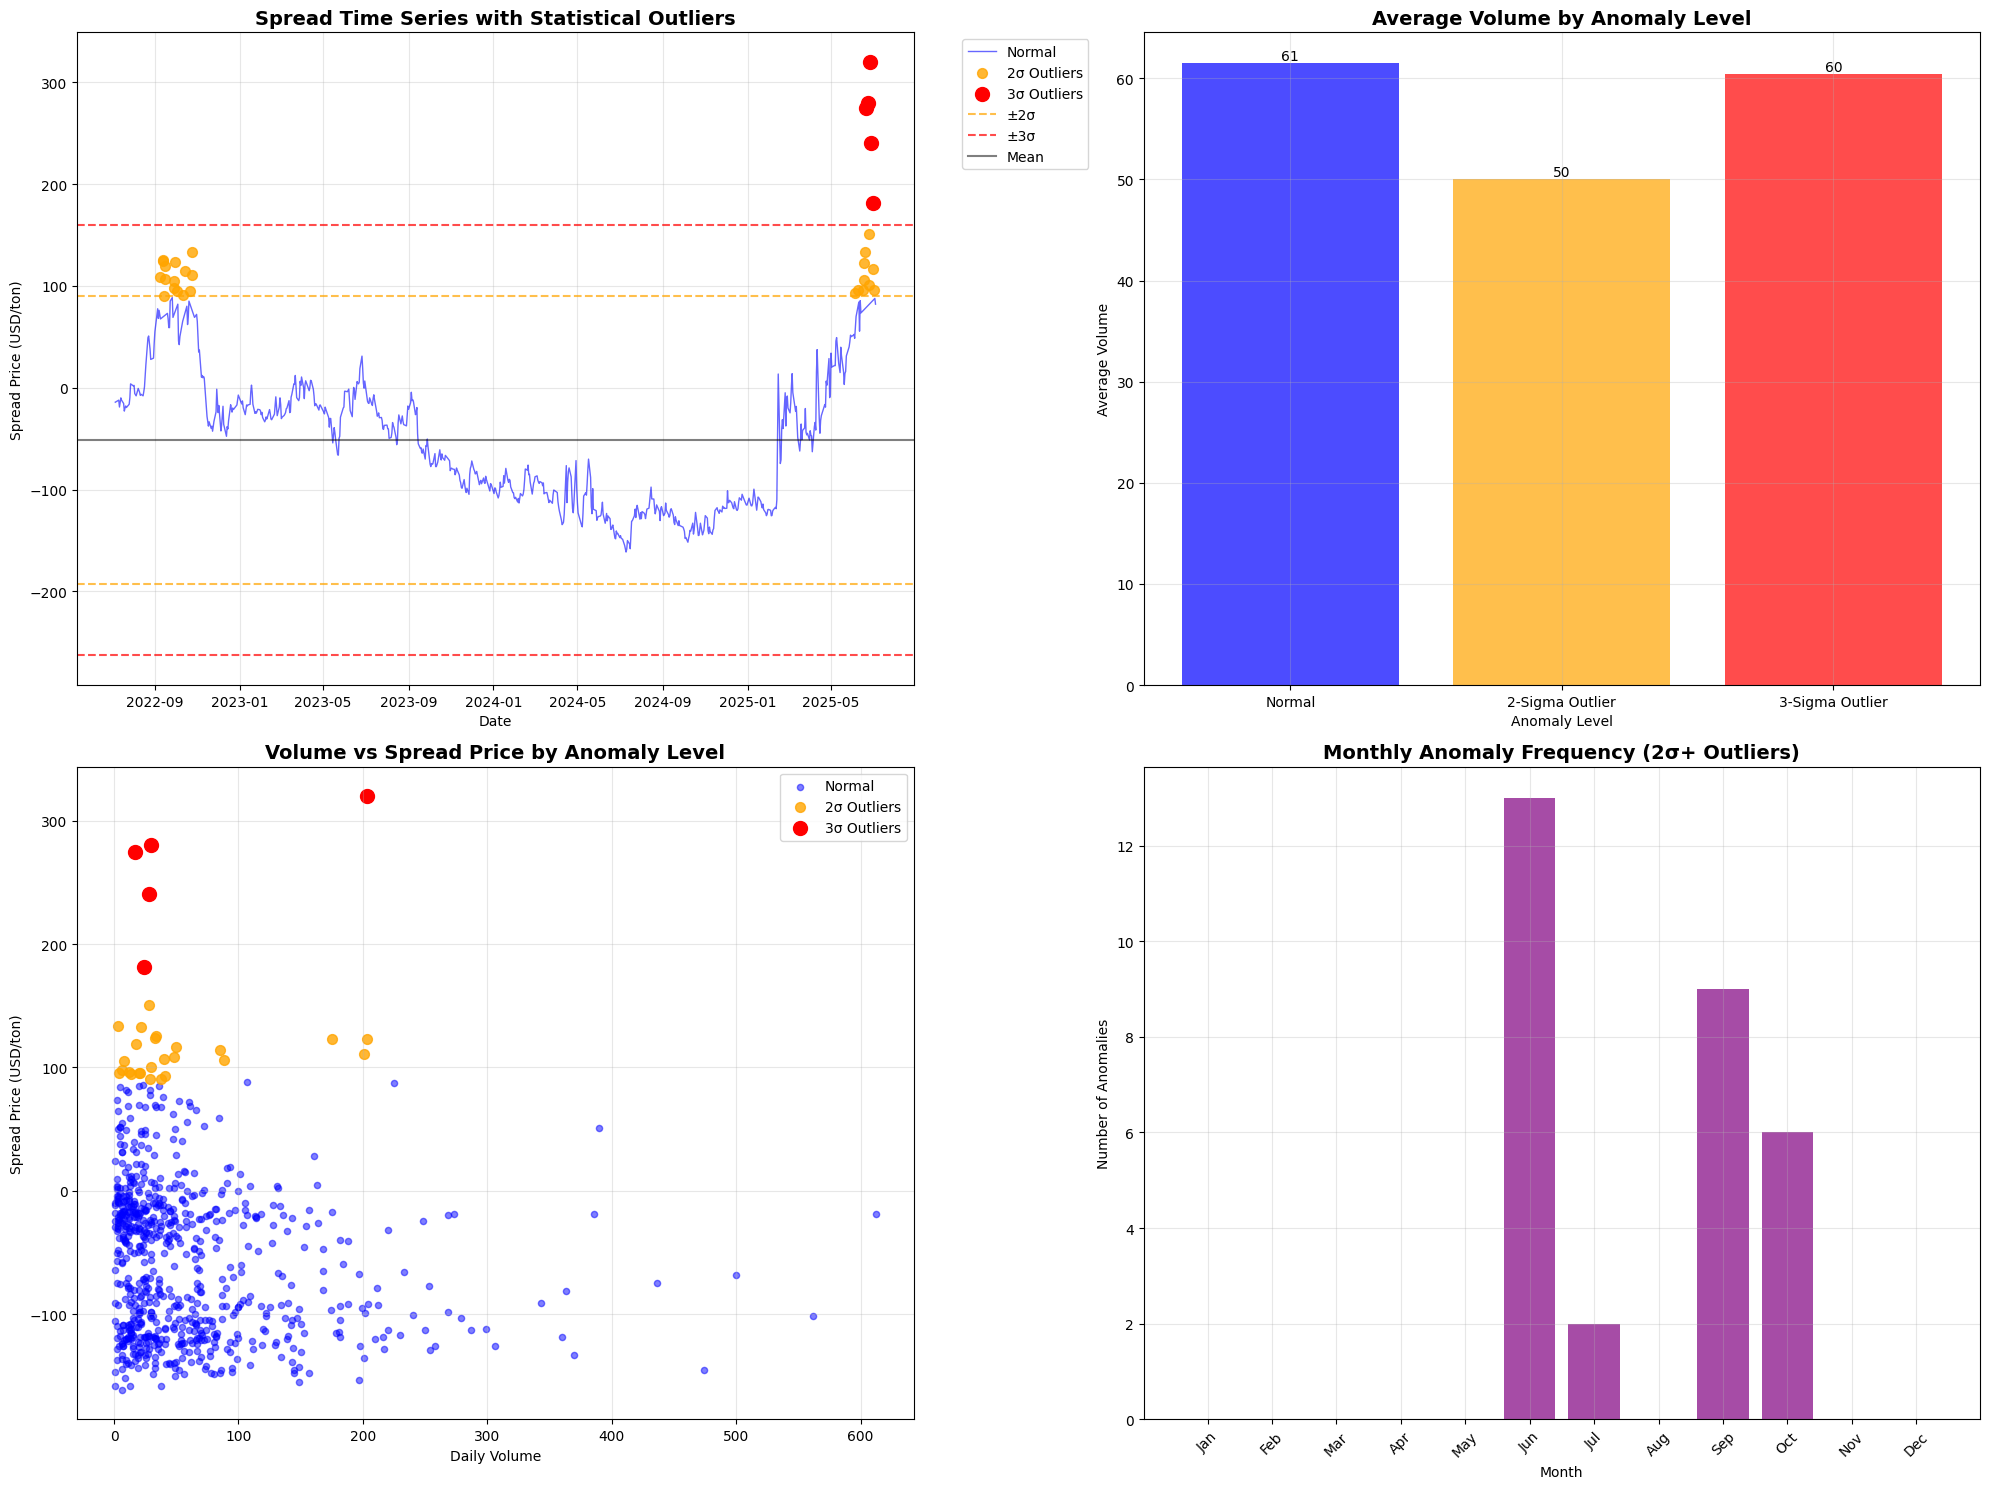

In [20]:
if spread_df is not None:
    # 取引機会可視化
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. スプレッド時系列with異常値ハイライト
    normal_data = spread_df_sorted[spread_df_sorted['anomaly_level'] == 'Normal']
    sigma2_data = spread_df_sorted[spread_df_sorted['anomaly_level'] == '2-Sigma Outlier']
    sigma3_data = spread_df_sorted[spread_df_sorted['anomaly_level'] == '3-Sigma Outlier']
    
    ax1.plot(normal_data['trade_date'], normal_data['spread_price'], 
             color='blue', alpha=0.6, linewidth=1, label='Normal')
    ax1.scatter(sigma2_data['trade_date'], sigma2_data['spread_price'], 
                color='orange', s=50, alpha=0.8, label='2σ Outliers', zorder=5)
    ax1.scatter(sigma3_data['trade_date'], sigma3_data['spread_price'], 
                color='red', s=100, alpha=1.0, label='3σ Outliers', zorder=6)
    
    # 統計的境界線
    ax1.axhline(y=upper_2sigma, color='orange', linestyle='--', alpha=0.7, label='±2σ')
    ax1.axhline(y=lower_2sigma, color='orange', linestyle='--', alpha=0.7)
    ax1.axhline(y=upper_3sigma, color='red', linestyle='--', alpha=0.7, label='±3σ')
    ax1.axhline(y=lower_3sigma, color='red', linestyle='--', alpha=0.7)
    ax1.axhline(y=spread_mean, color='black', linestyle='-', alpha=0.5, label='Mean')
    
    ax1.set_title('Spread Time Series with Statistical Outliers', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Spread Price (USD/ton)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 2. 異常値レベル vs 出来高
    level_order = ['Normal', '2-Sigma Outlier', '3-Sigma Outlier']
    volume_by_level = []
    for level in level_order:
        if level in anomaly_analysis.index:
            volume_by_level.append(anomaly_analysis.loc[level, 'avg_volume'])
        else:
            volume_by_level.append(0)
    
    bars2 = ax2.bar(range(len(level_order)), volume_by_level, 
                    color=['blue', 'orange', 'red'], alpha=0.7)
    ax2.set_title('Average Volume by Anomaly Level', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Anomaly Level')
    ax2.set_ylabel('Average Volume')
    ax2.set_xticks(range(len(level_order)))
    ax2.set_xticklabels(level_order)
    ax2.grid(True, alpha=0.3)
    
    # 値ラベル追加
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:,.0f}', ha='center', va='bottom')
    
    # 3. スプレッド vs 出来高 散布図（異常値色分け）
    ax3.scatter(normal_data['volume'], normal_data['spread_price'], 
               alpha=0.5, s=20, color='blue', label='Normal')
    ax3.scatter(sigma2_data['volume'], sigma2_data['spread_price'], 
               alpha=0.8, s=50, color='orange', label='2σ Outliers')
    ax3.scatter(sigma3_data['volume'], sigma3_data['spread_price'], 
               alpha=1.0, s=100, color='red', label='3σ Outliers')
    
    ax3.set_title('Volume vs Spread Price by Anomaly Level', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Daily Volume')
    ax3.set_ylabel('Spread Price (USD/ton)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. 月別異常値発生頻度
    monthly_anomalies = spread_df_sorted[spread_df_sorted['anomaly_level'] != 'Normal'].groupby('month_name').size().reindex(
        ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December'], fill_value=0)
    
    ax4.bar(range(len(monthly_anomalies)), monthly_anomalies.values, 
            color='purple', alpha=0.7)
    ax4.set_title('Monthly Anomaly Frequency (2σ+ Outliers)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Month')
    ax4.set_ylabel('Number of Anomalies')
    ax4.set_xticks(range(len(monthly_anomalies)))
    ax4.set_xticklabels([m[:3] for m in monthly_anomalies.index], rotation=45)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/spread_trading_opportunities.png', dpi=300, bbox_inches='tight')
    plt.show()

## 総合レポート

### 主要発見事項:

1. **スプレッド出来高パターン**: 
   - バックワーデーション vs コンタンゴでの取引行動の違い
   - 明確な季節性と曜日効果の存在

2. **流動性効率**:
   - 高出来高期間でのスプレッドボラティリティ低下
   - 効率的な価格発見メカニズムの確認

3. **市場参加者**:
   - 大口取引（機関投資家）の市場影響分析
   - 取引サイズ別の価格インパクト特性

4. **取引機会**:
   - 統計的異常値での裁定機会の特定
   - 低流動性期間での価格歪みリスク

### スプレッド取引戦略:

- **エントリー**: 2σ超異常値での逆張り取引
- **サイジング**: 出来高レベルに応じたポジション調整
- **タイミング**: 高効率期間での大口執行
- **リスク管理**: 3σ超異常値での損切り設定

### 実務への含意:

スプレッド取引において、出来高と価格異常値の組み合わせ分析により、効率的な取引執行と裁定機会の捕捉が可能であることが確認されました。特に、統計的境界を用いた客観的な取引シグナルの有効性が示されています。